# Convolutional autoencoder for 2D MNIST denoising!
 This code shows the example of an autoencoder applied on the MNIST dataset. It will also show the denoising use case.

 An autoencoder is a neural network that takes its input and tries to reconstruct the same input in its output layer.
 The crux is, that the architecture of the autoencoder includes a bottleneck layer which forces high-dimensional data into low-dimensional spaces.
 From these low dimensional spaces, the original input must be reconstructed. Hence, the autoencoder functions as some form of compressor.
 The following image shows the architectural design of an autoencoder.

 ![imgs/autoencoder.png](imgs/autoencoder.png)

 Most of the code and explainations can be found here:
 - https://blog.keras.io/building-autoencoders-in-keras.html
 - https://www.machinecurve.com/index.php/2019/12/26/how-to-visualize-the-encoded-state-of-an-autoencoder-with-keras/
 - https://stackoverflow.com/a/48612403/4162265

 ## Part 1: A simple autoencoder example
### Import all the necessary libraries
 This cell will load all the necessary libraries to run the code. The "if gpus"-clause deals with an issue related to the GPU execution of this code.
 The issue is very specific to the machine currently used. Hence, that part can be ignored if run on an CPU or if GPU execution runs smoothly without it.

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import numpy as np


### Load the dataset
 This code snippet will load the dataset. In this case the data set is a very simple data set of white handwritten digits on a black background.
 The name of the data set is MNIST and it is frequently used for testing or development purposes.
 The rational goes; if it works on MNIST it will probably work on other data sets, too, if the hyper params are tuned accordingly.
 (Personal remark: This is not always the case, because MNIST is a very very easy data set compared to other data sets.)

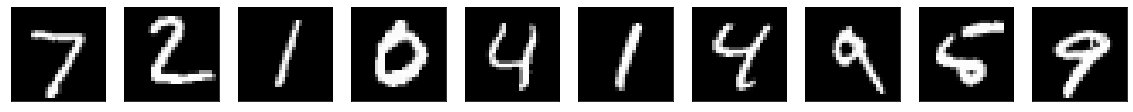

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


 ### Design the autoencoder architecture
 This part creates three models. The encoder, the decoder and the full autoencoder. It will also show a summary of the model.

 - The encoder will boil the high dimensional image down to a lower dimensional space.
 In this case 784 dimensions into 8 dimensions (per default).
 - The decoder will take an vector and try to regenerate the original image.
 Meaning, that 8 dimensions will be reconstructed back into 784 dimensions
 - The autoencoder model glues both, the encoder and decoder, together.


 Many tutorials do not separate these three models.
 However, this modularisation will provide us with a simple way to use the encoder and decoder separately after training. Something which many tutorials fail to explain.


In [3]:
def Encoder(output_dim=8):
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
    e = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    e = MaxPooling2D((2, 2), padding='same')(e)
    e = Conv2D(8, (3, 3), activation='relu', padding='same')(e)
    e = MaxPooling2D((2, 2), padding='same')(e)
    e = Conv2D(8, (3, 3), activation='relu', padding='same')(e)
    e = MaxPooling2D((2, 2), padding='same')(e)
    flat_e = Flatten()(e)
    repr_e = Dense(output_dim, activation='sigmoid')(flat_e)
    return Model(input_img, repr_e), [output_dim, flat_e.shape[1], e.shape]


def Decoder(bridging_shapes):
    input_img = Input(shape=(bridging_shapes[0],))  # adapt this if using `channels_first` image data format
    d = Dense(bridging_shapes[1])(input_img)
    d = tf.reshape(d, [-1] + list(bridging_shapes[2][1:]))
    d = Conv2D(8, (3, 3), activation='relu', padding='same')(d)
    d = UpSampling2D((2, 2))(d)
    d = Conv2D(8, (3, 3), activation='relu', padding='same')(d)
    d = UpSampling2D((2, 2))(d)
    d = Conv2D(16, (3, 3), activation='relu')(d)
    d = UpSampling2D((2, 2))(d)
    d = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d)
    return Model(input_img, d)


# define input to the model:
x = Input(shape=(28, 28, 1))
encoder, bridging_shapes = Encoder(5)
encoder.summary()
decoder = Decoder(bridging_shapes)
decoder.summary()
# make the model:
autoencoder = Model(x, decoder(encoder(x)))
# autoencoder.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)          

 ### Compile and fit/train the model.
 What this code does is pretty obvious. Don't you think?

In [4]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=50, batch_size=16, shuffle=True, validation_data=(x_test, x_test))


Epoch 1/50
3750/3750 [==============================] - 10s 3ms/step - loss: 0.1890 - val_loss: 0.1672
Epoch 2/50
3750/3750 [==============================] - 9s 3ms/step - loss: 0.1645 - val_loss: 0.1610
Epoch 3/50
3750/3750 [==============================] - 10s 3ms/step - loss: 0.1609 - val_loss: 0.1592
Epoch 4/50
3750/3750 [==============================] - 10s 3ms/step - loss: 0.1590 - val_loss: 0.1575
Epoch 5/50
3750/3750 [==============================] - 10s 3ms/step - loss: 0.1578 - val_loss: 0.1584
Epoch 6/50
3750/3750 [==============================] - 10s 3ms/step - loss: 0.1569 - val_loss: 0.1555
Epoch 7/50
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1563 - val_loss: 0.1558
Epoch 8/50
3750/3750 [==============================] - 10s 3ms/step - loss: 0.1558 - val_loss: 0.1556
Epoch 9/50
3750/3750 [==============================] - 10s 3ms/step - loss: 0.1553 - val_loss: 0.1542
Epoch 10/50
3750/3750 [==============================] - 10s 3ms/step - lo

 ### Showing the results
 Here you can see the trained model in action. You can also see how the encoder and the decoder models are used separately.
 That's great, because now we can also display the actual vectors the high-dimensional images where boiled down to.

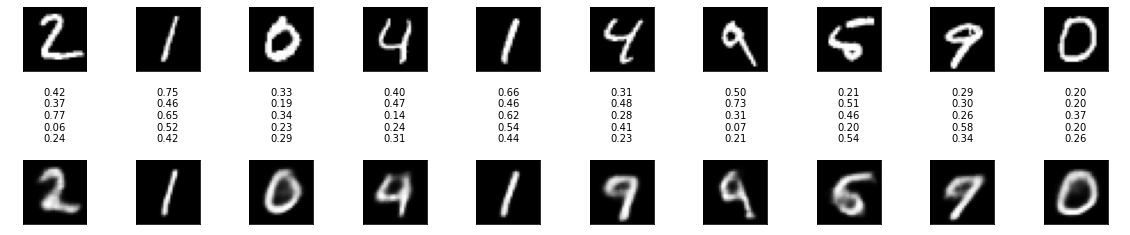

In [5]:
encodings = encoder.predict(x_test)
decodings = decoder.predict(encodings)

n = 10
rows = 3
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # display original
    ax = plt.subplot(rows, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    encoding_strings = "\n".join([f"{feature:.2f}" for feature in encodings[i]])
    ax = plt.subplot(rows, n, i + n)
    ax.text(0.5, 0.5, encoding_strings, horizontalalignment='center', verticalalignment='center')
    ax.axis('off')
    # display reconstruction
    ax = plt.subplot(rows, n, i + 2 * n)
    plt.imshow(decodings[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


 ## Part 2: Denoising noisy images
 ### Adding some noise to the digits
 This part will show how noisy images can be denoised using the autoencoder.
 Most of the code will remain very similar.
 The next cell adds some random noise to the mnist images, constructs the model and trains it.

In [8]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# define input to the model:
x = Input(shape=(28, 28, 1))
encoder, bridging_shapes = Encoder(5)
decoder = Decoder(bridging_shapes)
autoencoder = Model(x, decoder(encoder(x)))

# compile the model:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train, epochs=50, batch_size=16, shuffle=True, validation_data=(x_test_noisy, x_test))


Epoch 1/50
3750/3750 [==============================] - 10s 3ms/step - loss: 0.2083 - val_loss: 0.1811
Epoch 2/50
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1790 - val_loss: 0.1756
Epoch 3/50
3750/3750 [==============================] - 10s 3ms/step - loss: 0.1746 - val_loss: 0.1718
Epoch 4/50
3750/3750 [==============================] - 10s 3ms/step - loss: 0.1722 - val_loss: 0.1709
Epoch 5/50
3750/3750 [==============================] - 10s 3ms/step - loss: 0.1706 - val_loss: 0.1694
Epoch 6/50
3750/3750 [==============================] - 10s 3ms/step - loss: 0.1694 - val_loss: 0.1685
Epoch 7/50
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1686 - val_loss: 0.1676
Epoch 8/50
3750/3750 [==============================] - 10s 3ms/step - loss: 0.1679 - val_loss: 0.1668
Epoch 9/50
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1673 - val_loss: 0.1660
Epoch 10/50
3750/3750 [==============================] - 10s 3ms/step - l

 Voilà!

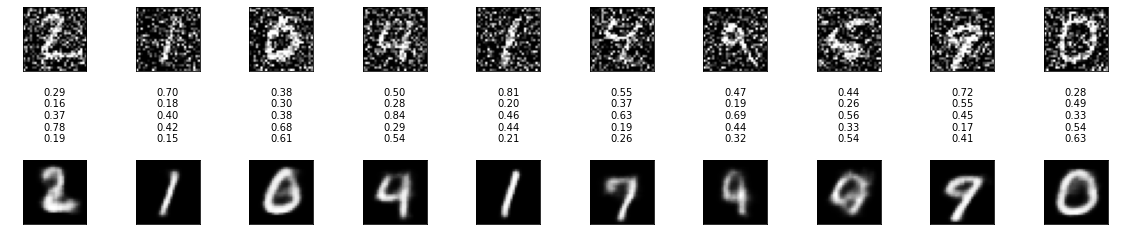

In [9]:
encodings = encoder.predict(x_test_noisy)
decodings = decoder.predict(encodings)

n = 10
rows = 3
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # display original
    ax = plt.subplot(rows, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    encoding_strings = "\n".join([f"{feature:.2f}" for feature in encodings[i]])
    ax = plt.subplot(rows, n, i + n)
    ax.text(0.5, 0.5, encoding_strings, horizontalalignment='center', verticalalignment='center')
    ax.axis('off')
    # display reconstruction
    ax = plt.subplot(rows, n, i + 2 * n)
    plt.imshow(decodings[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
